Firstly, import the fortran disk model routines and the python likelihood functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profileell
from diskfit import likelihood, utils
from scipy.optimize import minimize

Load the continuum subtracted spectrum. Establish the redshift and narrow line width in Angstroms. 

In [2]:
fn = '../data/ZTF18aahiqst_subtracted.txt'
wl,flux,fluxerr = utils.readspec(fn)
z = 0.0745
narrowmu = 3.9

Extract the region of the spectrum containing the double-peaked profile, and store the size of the spectrum in npix

In [3]:
olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
wavemin = 6300  # minimum wavelength (Angstrom)
wavemax = 6900  # maximum wavelength (Angstrom)
wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
indwave = np.argwhere((wave>wavemin)&(wave<wavemax))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
flux = flux[indwave]
fluxerr = fluxerr[indwave]
npix = wl.shape[0]

Set all the parameters which will remain fixed to pre-determined values during the fitting

In [4]:
# Integration, units, normalization

maxstep = 400
maxwave = 10000
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]fluxunits = 'flam' # flux density units (fnu/flam) [fnu]

# Fixed parameters for elliptical disk size and emission properties

q1 = 1.7 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)
smooth = 'y'#smoothly varying eccentricity (y/n)[n]

Create a dictionary of the fixed parameter names and values

In [5]:
fixed_values = [z,narrowmu,q1,q2,xib,maxstep,nstep,smooth,olambda,npix]
fixed_labels = ['z','narrowmu','q1','q2','xib','maxstep','nstep','smooth','olambda','npix']
fixed = dict(zip(fixed_labels,fixed_values))

Set initial guesses for the parameters to be fitted

In [6]:
angi = 25 #disk inclination angle (degrees)
xi1 = 134 #inner disk radius (GM/c^2)
xi2 = 34 #outer disk radius (multiple of xi1)
broad = 600 #broadening parameter (km/s)
ell = 0.8               #eccentricity (< 1), outer eccentricity if varying smoothly
phi0 = 220.0             #major axis orientation (0-360 deg)

Create a dictionary of fitted parameter names and values

In [7]:
fitted_labels = ['xi1','xi2','broad','angi','ell','phi0']
initial = [xi1,xi2,broad,angi,ell,phi0]
fitted = dict(zip(fitted_labels,initial))

Set wavelengths of narrow emission lines to be included in the fit and create the array of line profiles

In [8]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]

Plot initial model against spectrum

In [9]:
modelguess = likelihood.model_linefit_ell(initial, wl, flux, fluxerr, lines, fixed, fitted)

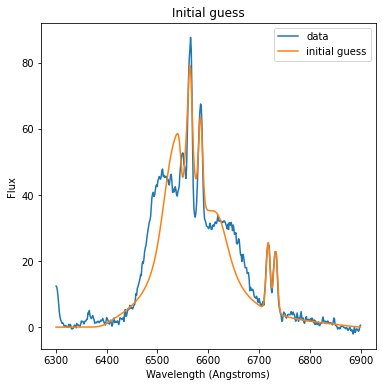

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+z),flux,label='data')
plt.plot(wl/(1+z),modelguess,label='initial guess')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

Establish bounds for fitted parameters. These will be used to make a uniform prior.

In [11]:
angimax = 89.9
angimin= 0.1
xi1min = 100
xi1max = 2000
xi2min = 1.01
xi2max = 40
broadmin = 0
broadmax = 1000
ellmin = 0.0
ellmax=0.99
phi0min=0.0
phi0max=360.0
diskmins = [xi1min,xi2min,broadmin,angimin,ellmin,phi0min]
diskmax = [xi1max,xi2max,broadmax,angimax,ellmax,phi0max]

In [12]:
lp = likelihood.logprob_ell(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

Use scipy.optimize.minimize to find a simple solution for the fitted parameters

In [14]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)
print('Best-fit parameter values', soln.x)

Best-fit parameter values [173.01888641   8.90187508 393.80994216  21.87238869   0.71780407
 189.20566696]


This fit succeeeded because we chose a reasonable initial guess with a high ellipticity. If we had started with a zero ellipticity guess, it would have found our old circular solution!

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+soln.x[4]),flux,label='data')
plt.plot(wl/(1+soln.x[4]),modelfit,label='fitted model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

Now import the emcee module to sample the parameter space, with walkers initialized around the best fit parameters from the previous step. Run the sampler for 1000 iterations and save the progress to file. 

In [24]:
import emcee
pos = soln.x + 1e-1 * soln.x * np.random.randn(20, soln.x.shape[0])
#pos = initial + 1e-1 * initial * np.random.randn(20, initial.shape[0])
nwalkers, ndim = pos.shape
filename ='ell_emcee.h5'
backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
#sampler.run_mcmc(pos, 1000, progress=True)

Print the parameters and uncertainties found by the sampler

In [29]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=100, flat=True)
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

It looks like the sampler did a poor job of moving away from the zero ellipticity solution found by the minimization routine. We should start with walkers over a larger range!

Make a corner plot of the parameter samples

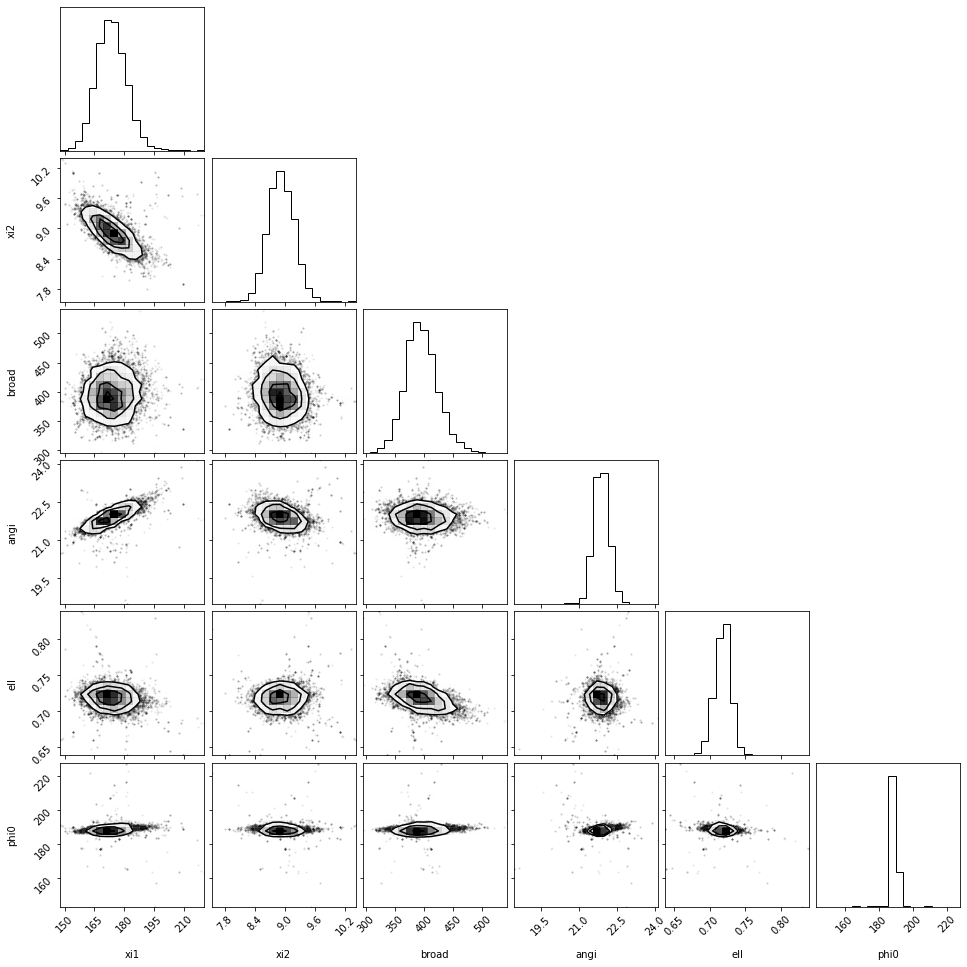

In [30]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

Plot the sampler chains 

<Figure size 432x432 with 0 Axes>

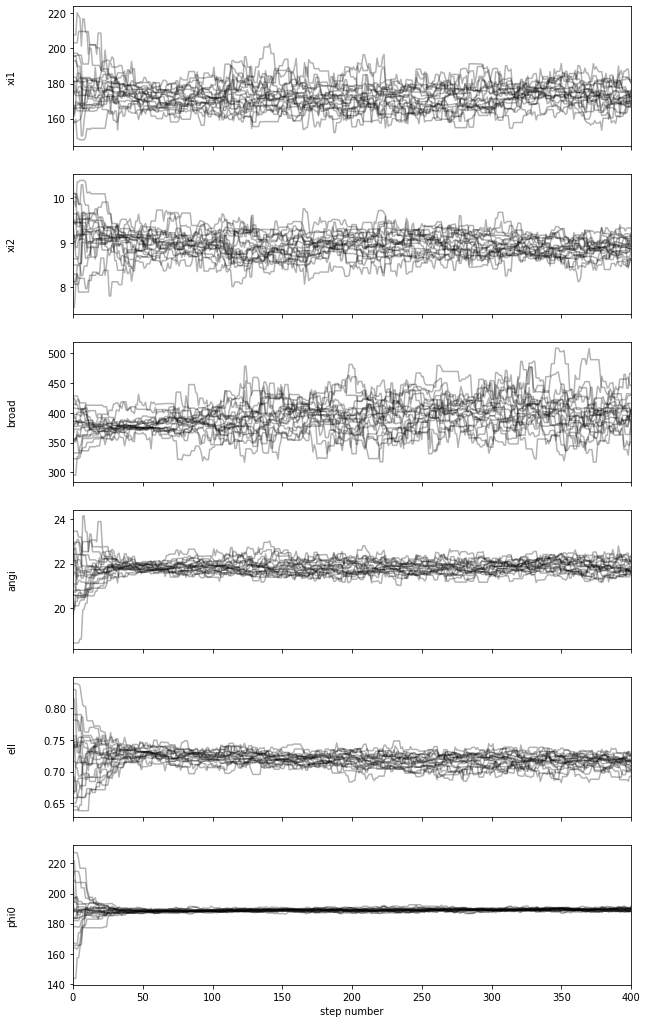

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[400:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 400)
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

We need to run the sampler for longer. Another 500 iterations should be done to see what happens.

Plot the range of good fits found by the sampler

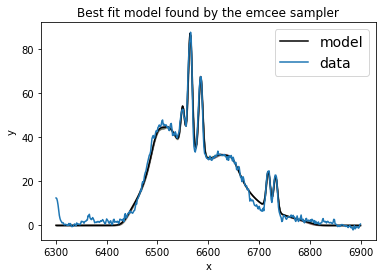

<Figure size 432x288 with 0 Axes>

In [28]:
from ultranest.plot import PredictionBand
band = PredictionBand(wl/(1+z))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    modelfit = lp.test(sample)
    band.add(modelfit)
    plt.plot(wl/(1+z),modelfit,alpha=0.1)

band.line(color='k',label='model')
# add 1 sigma quantile
band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2);

plt.plot(wl/(1+z),flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.clf()